## 統計學習與深度學習 HW4
##### B08705038 資管四 郭子麟

In [ ]:
!nvidia-smi

Sun Dec  4 05:43:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Multilayer Perceptrons for Regression
本次作業的主角是 Multilayer perceptrons (MLP)。我們將以MLP建構迴歸模型，探討各項相關議題。


#### Dataset: Million Songs Dataset
本次作業將使用"Million Songs Dataset"作為訓練與測試資料。請使用`pickle.load()`載入*msd_full.pickle*。這個資料集已經切割好了訓練與測試資料，並存放在一個Dictionary的結構。這個Dictionary有四個元素，x_train, y_train, x_test, y_test，分別對應到訓練特徵、訓練標記(Label)、測試特徵、測試標記。 標記變數 (label variable; i.e., $y$) 是歌曲發行年度。特徵為歌曲的聲音特性。迴歸任務為預測歌曲年分。

#### Prediction Performance and Loss Function
模型訓練應主要使用Sum of Squared Error (SSE)建構Loss Function，另外我們也會練習使用其他種類的Loss Function。為了讓圖表易於理解，不論Loss Function為何，報告預測能力應使用Root Mean Squared Error (RMSE)。使用SSE或RMSE建構Loss Function在本質上沒有差別。但SSE計算成本稍低，而RMSE較有直觀意義。


#### Subtraining, Validation, and Test Datasets
*msd_full.pickle* 檔案中的訓練資料已經隨機排序過。你應該使用訓練資料最後10%的資料做為Validation Set。其餘的前90%做為Subtraining Set。使用Subtraining Set來訓練資料，並以Validation Set作為參數調教與Early Stopping的依據。Test RMSE應使用測試資料計算得之。

所有特徵應該標準化(均數為零，變異數為一)。標準化應該以訓練資料(注意不是Test Set or Subtraining Set)的統計量為之。標記變數(i.e., $y$)應將均數平移至0 (依照訓練資料的統計量)。標記變數的變異數不要調整。


#### Minibatch, Epoch, and Early Stopping
如果沒有特別說明，模型訓練時應以大小為1,000個資料點的Minibatch為之。模型使用一個Minibatch的資料更新參數之後稱為經歷了一個Batch。當所有Subtraining資料已經用來更新過模型參數，稱為經過了一個Epoch。

模型訓練應使用Early Stopping決定最佳的模型。模型訓練時每100個Batch計算一次Training and Validation RMSE。如果Validation為歷史最低，則記下當下的模型參數與當時已進行的Batch數量，稱為best_step_count。如由best_step_count起算已經經過了5,000個Batch而沒有更好的Validation RMSE，則停止模型訓練，並以best_step_count時的模型參數做為最後的模型訓練結果。如果模型訓練最多執行100個epoch。如果模型已經執行了100個epoch而沒有Early Stop，則應使用歷史最佳的Validation RMSE所對應到的模型參數計算Test RMSE。


#### Implementation Restriction
使用Pytorch建構MLP模型。Ordinary Least Square (OLS)模型訓練沒有限制使用何種套件。

### 資料載入
使用下面的程式碼載入資料:

In [ ]:
!mkdir data
!cp /content/drive/MyDrive/msd_full.pickle ./data

In [4]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### 回答下面問題

#### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [ ]:
# use ols model to fit the data and list first 5 features' weights and the RMSE. There should be no regularization.
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

ols = linear_model.LinearRegression()
ols.fit(X_subtrain, Y_subtrain)
Y_pred = ols.predict(X_valid)
print("RMSE = ", np.sqrt(mean_squared_error(Y_valid, Y_pred)))
print("First 5 features' weights = ", ols.coef_[0:5])

RMSE =  9.519576
First 5 features' weights =  [ 5.2934246  -2.8868294  -1.5276392   0.06306529 -0.33957988]


#### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。


##### Construct Dataset and DataLoader

##### Construct a MLP Model Class

In [5]:
import copy
import matplotlib.pyplot as plt
import torch
from torch.utils import data
import numpy as np

class L2L1Loss(torch.nn.Module):
    def __init__(self, loss_z):
        super(L2L1Loss, self).__init__()
        self.loss_z = loss_z
    def forward(self, Y_pred, Y):
        return self.loss_z * torch.nn.MSELoss(reduction='sum')(Y_pred, Y) + (1 - self.loss_z) * torch.nn.L1Loss(reduction='sum')(Y_pred, Y)

class CustomizedL2Loss(torch.nn.Module):
    def __init__(self, loss_z):
        super(CustomizedL2Loss, self).__init__()
        self.loss_z = loss_z
    def forward(self, Y_pred, Y):
        return self.loss_z * torch.nn.MSELoss(reduction='sum')(Y_pred, Y) + (1 - self.loss_z) * abs(torch.nn.L1Loss(reduction='sum')(Y_pred, Y))

class MSDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

class MyMLP():
    def __init__(self, X_subtrain, Y_subtrain, X_valid, Y_valid, H = 45, lr = 0.00001, optimizer_type = 0, loss_type = 0, wd = 0, mom = 0, use_dropout = False, dropout_rate = 0.5, loss_z = 0.5):
        """
        #### Parameters
        - X_subtrain: training data
        - Y_subtrain: training label
        - X_valid: validation data
        - Y_valid: validation label
        - H: the number of hidden units for each layer. Default is 45.
        - lr: learning rate. Default: 0.00001
        - wd: weight decay. Default: 0
        - mom: momentum. Default: 0
        - loss_type: the type of loss function. 0: SSE, 1: L2 + L1, 2: L2 customized. Default: 0
        - optimizer_type: the type of optimizer. 0: SGD, 1: Adam. Default: 0
        - use_dropout: whether to use dropout. Default: False
        - dropout_rate: the rate of dropout. 0.5 by default
        - loss_z: the parameter for L2 + L1 loss function. 0.5 by default
        """
        self.train_dataset = MSDataset(X_subtrain, Y_subtrain)
        self.valid_dataset = MSDataset(X_valid, Y_valid)
        self.train_loader = data.DataLoader(self.train_dataset, batch_size=1000, shuffle=True)
        self.valid_loader = data.DataLoader(self.valid_dataset, batch_size=1000, shuffle=False)
        self.H = H
        self.lr = lr
        self.wd = wd
        self.mom = mom
        self.loss_type = loss_type
        self.optimizer_type = optimizer_type
        self.use_dropout = use_dropout
        self.dropout_rate = dropout_rate
        self.loss_z = loss_z
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.__get_model_sequential()
        self.loss_function = self.__get_loss_function()
        self.optimizer = self.__get_optimizer()

    def __get_model_sequential(self):
        if self.use_dropout:
            model = torch.nn.Sequential(
                torch.nn.Linear(90, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, 1)
            )
        else:
            model = torch.nn.Sequential(
                torch.nn.Linear(90, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, 1)
            )
        model.float().to(self.device)
        return model
    def __get_loss_function(self):
        if self.loss_type == 0: # SSE
            loss_function = torch.nn.MSELoss(reduction='sum')
        elif self.loss_type == 1: # L2 + L1
            loss_function = L2L1Loss(self.loss_z)
        else: # L2 customized
            loss_function = CustomizedL2Loss(self.loss_z)
        return loss_function
    def fit(self, max_epoch = 100, verbose = True, patience_batch_num = 5000, model_path = 'model.ckpt'):
        """
        For every 100 batches, print the training loss and validation loss.\n
        It will return two lists: training loss and validation loss.
        #### Parameters
        - max_epoch: the maximum number of epochs. Default: 100
        - verbose: whether to print the training information. Default: True
        - patience_batch_num: the number of batches to wait before early stopping. Default: 5000
        """
        cur_step = 0
        cur_epoch = 0
        patience = 0
        best_valid_loss = np.inf
        train_loss_list = []
        valid_loss_list = []
        while cur_epoch < max_epoch:
            for _, (batch_X, batch_Y) in enumerate(self.train_loader):
                self.model.train() # switch to train mode
                self.optimizer.zero_grad()
                batch_X = batch_X.to(self.device)
                batch_Y = batch_Y.reshape((-1, 1)).to(self.device)
                batch_Y_pred = self.model(batch_X)
                loss = self.loss_function(batch_Y_pred, batch_Y)
                loss.backward()
                self.optimizer.step()
                cur_step += 1
                if cur_step % 100 == 0:
                    # train loss should use RMSE for the training set
                    train_loss = 0
                    train_size = 0
                    self.model.eval()
                    for _, (batch_X, batch_Y) in enumerate(self.train_loader):
                        batch_X = batch_X.to(self.device)
                        batch_Y = batch_Y.reshape((-1, 1)).to(self.device)
                        batch_Y_pred = self.model(batch_X)
                        train_loss += torch.nn.MSELoss(reduction='sum')(batch_Y_pred, batch_Y).item()
                        train_size += batch_X.shape[0]
                    rmse_train_loss = np.sqrt(train_loss / train_size)
                    train_loss_list.append(rmse_train_loss)
                    valid_loss = 0
                    valid_rmse_loss = 0
                    valid_size = 0
                    for _, (batch_X, batch_Y) in enumerate(self.valid_loader):
                        valid_size += batch_X.shape[0]
                        batch_X = batch_X.to(self.device)
                        batch_Y = batch_Y.reshape((-1, 1)).to(self.device)
                        batch_Y_pred = self.model(batch_X)
                        loss = self.loss_function(batch_Y_pred, batch_Y)
                        valid_loss += loss.item()
                        valid_rmse_loss += torch.nn.MSELoss(reduction='sum')(batch_Y_pred, batch_Y).item()
                    valid_rmse_loss = np.sqrt(valid_rmse_loss / valid_size)
                    valid_loss_list.append(valid_rmse_loss)
                    if valid_loss < best_valid_loss:
                        best_valid_loss = valid_loss
                        best_model = copy.deepcopy(self.model)
                        patience = 0
                    else:
                        patience += 1
                    if verbose:
                        print("Epoch: {}, Step: {}, Train Loss: {}, Valid Loss: {}".format(cur_epoch, cur_step, train_loss_list[-1], valid_loss_list[-1]))
                    if patience >= patience_batch_num:
                        self.model = best_model
                        print("Early stopping at epoch {}, step {}".format(cur_epoch, cur_step))
                        torch.save(self.model, model_path)
                        return train_loss_list, valid_loss_list
            cur_epoch += 1
        self.model = best_model
        torch.save(self.model, model_path)
        return train_loss_list, valid_loss_list
    def __get_optimizer(self):
        if self.optimizer_type == 0: # SGD
            optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=self.wd, momentum=self.mom)
        else: # Adam
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        return optimizer

In [2]:
def calculate_test_rmse(model, X_test, Y_test):
    test_dataset = MSDataset(X_test, Y_test)
    test_loader = data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loss = 0
    test_size = 0
    for _, (batch_X, batch_Y) in enumerate(test_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.reshape((-1, 1)).to(device)
        batch_Y_pred = model(batch_X)
        test_loss += torch.nn.MSELoss(reduction='sum')(batch_Y_pred, batch_Y).item()
        test_size += batch_X.shape[0]
    test_rmse_loss = np.sqrt(test_loss / test_size)
    return test_rmse_loss

##### Construct a MLP Model and Train

In [ ]:
q2_mlp = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=45,
    lr=0.00001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=0,
    use_dropout=False
)
train_loss_list, valid_loss_list = q2_mlp.fit(max_epoch=100, verbose=True, patience_batch_num=5000, model_path='q2_mlp.ckpt')

Epoch: 0, Step: 100, Train Loss: 9.991095267968475, Valid Loss: 9.947883158336252
Epoch: 0, Step: 200, Train Loss: 9.043213823832458, Valid Loss: 8.973001691702606
Epoch: 0, Step: 300, Train Loss: 8.939802725644984, Valid Loss: 8.884352073443294
Epoch: 0, Step: 400, Train Loss: 8.983293837944046, Valid Loss: 8.921108270821941
Epoch: 1, Step: 500, Train Loss: 8.821180968863858, Valid Loss: 8.78018643079955
Epoch: 1, Step: 600, Train Loss: 8.792730461404659, Valid Loss: 8.752487296066953
Epoch: 1, Step: 700, Train Loss: 8.748214699132635, Valid Loss: 8.705454730923588
Epoch: 1, Step: 800, Train Loss: 8.745971351819644, Valid Loss: 8.71993192510473
Epoch: 2, Step: 900, Train Loss: 8.745709111459579, Valid Loss: 8.723014076298416
Epoch: 2, Step: 1000, Train Loss: 8.698302019023007, Valid Loss: 8.688137410642652
Epoch: 2, Step: 1100, Train Loss: 8.697569482671522, Valid Loss: 8.686405671593237
Epoch: 2, Step: 1200, Train Loss: 8.659579219780065, Valid Loss: 8.65800456523078
Epoch: 3, Step: 

In [ ]:
best_model_q2 = torch.load('q2_mlp.ckpt')
test_rmse_loss = calculate_test_rmse(best_model_q2, X_test, Y_test)
print("Test RMSE Loss: {}".format(test_rmse_loss))

Test RMSE Loss: 8.800802179448848


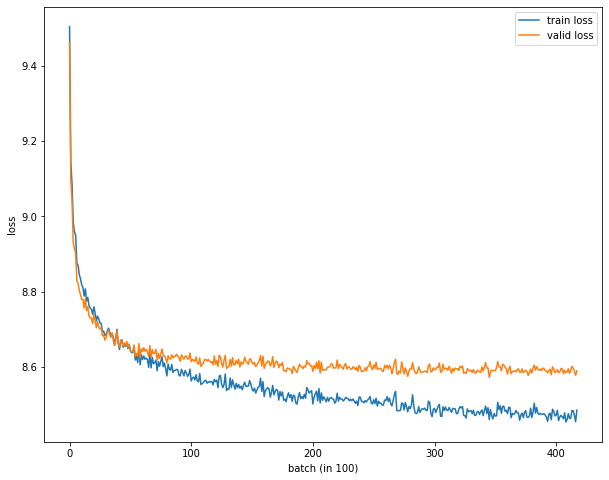

In [ ]:
# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
def draw_loss(train_loss_list, valid_loss_list):
        """
        Draw the training loss and validation loss.
        """
        plt.plot(train_loss_list, label = "train loss")
        plt.plot(valid_loss_list, label = "valid loss")
        plt.xlabel("batch (in 100)")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
draw_loss(train_loss_list, valid_loss_list)

從上圖可以看出，在訓練過程中，Training RMSE 與 Validation RMSE 在前幾千個 Batch 都在下降。  
但後來 Validation RMSE 逐漸停在 8.6 左右，而 Training RMSE 仍在下降讓差距越來越大，代表模型可能開始有 Overfitting 的跡象。

#### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。


In [ ]:
mlp_90 = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=90,
    lr=0.00001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=0,
    use_dropout=False
)
train_loss_list, valid_loss_list = mlp_90.fit(
    max_epoch=100, 
    verbose=True, 
    patience_batch_num=5000, 
    model_path='q3_mlp_90.ckpt'
)

Epoch: 0, Step: 100, Train Loss: 9.839815017507126, Valid Loss: 9.814369551559734
Epoch: 0, Step: 200, Train Loss: 9.033181272205535, Valid Loss: 8.984130010393514
Epoch: 0, Step: 300, Train Loss: 8.920812131723691, Valid Loss: 8.879889801261035
Epoch: 0, Step: 400, Train Loss: 8.85807569027006, Valid Loss: 8.807489562696778
Epoch: 1, Step: 500, Train Loss: 9.228593043933627, Valid Loss: 9.207619072654419
Epoch: 1, Step: 600, Train Loss: 8.794256154576987, Valid Loss: 8.774127802135219
Epoch: 1, Step: 700, Train Loss: 8.73649967566084, Valid Loss: 8.714671226314493
Epoch: 1, Step: 800, Train Loss: 8.702913563221678, Valid Loss: 8.710904595249785
Epoch: 2, Step: 900, Train Loss: 8.724080380824097, Valid Loss: 8.737643456684214
Epoch: 2, Step: 1000, Train Loss: 8.660138489543279, Valid Loss: 8.671764712291587
Epoch: 2, Step: 1100, Train Loss: 8.621660033611844, Valid Loss: 8.65740381348656
Epoch: 2, Step: 1200, Train Loss: 8.596212666803805, Valid Loss: 8.627063078225108
Epoch: 3, Step: 

In [ ]:
q3_mlp_90_best_model = torch.load('q3_mlp_90.ckpt')
test_rmse_loss = calculate_test_rmse(q3_mlp_90_best_model, X_test, Y_test)
print(f"Test RMSE Loss for 90 hidden units: {test_rmse_loss}")

Test RMSE Loss for 90 hidden units: 8.824939635001625


In [ ]:
mlp_180 = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=180,
    lr=0.00001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=0,
    use_dropout=False
)
train_loss_list, valid_loss_list = mlp_180.fit(
    max_epoch=100, 
    verbose=True, 
    patience_batch_num=5000, 
    model_path='q3_mlp_180.ckpt'
)

Epoch: 0, Step: 100, Train Loss: 9.762773435937175, Valid Loss: 9.72437337728604
Epoch: 0, Step: 200, Train Loss: 8.933288157975946, Valid Loss: 8.878353351058326
Epoch: 0, Step: 300, Train Loss: 8.961054331286567, Valid Loss: 8.905003799988245
Epoch: 0, Step: 400, Train Loss: 8.828895391504718, Valid Loss: 8.792201202023026
Epoch: 1, Step: 500, Train Loss: 8.895737112881474, Valid Loss: 8.865517077137692
Epoch: 1, Step: 600, Train Loss: 8.69450669542885, Valid Loss: 8.674454258141354
Epoch: 1, Step: 700, Train Loss: 8.682571490382028, Valid Loss: 8.685526698047148
Epoch: 1, Step: 800, Train Loss: 8.622623468223562, Valid Loss: 8.637789665198763
Epoch: 2, Step: 900, Train Loss: 8.577157590386301, Valid Loss: 8.60461878077653
Epoch: 2, Step: 1000, Train Loss: 8.550915400035679, Valid Loss: 8.590970958875289
Epoch: 2, Step: 1100, Train Loss: 8.533694665228202, Valid Loss: 8.582343570223141
Epoch: 2, Step: 1200, Train Loss: 8.517200602059388, Valid Loss: 8.584848598329431
Epoch: 3, Step: 

In [ ]:
q3_mlp_180_best_model = torch.load('q3_mlp_180.ckpt')
test_rmse_loss = calculate_test_rmse(q3_mlp_180_best_model, X_test, Y_test)
print(f"Test RMSE Loss for 90 hidden units: {test_rmse_loss}")

Test RMSE Loss for 90 hidden units: 8.842014063568538


##### Discussion on Test RMSE with different H (H = 45, 90, 180)
由上可知，不同的 H 其所對應的 Test RMSE 如下：
* H = 45: 8.934501721928912
* H = 90: 8.965207331652502
* H = 180: 8.918703611390761

從這邊並沒有看出不同 H 是否會有特別的走向，只能看出 180 個 Hidden Nodes 的 Test RMSE 最小，但是差距不大，90 個 Hidden Nodes 的 Test RMSE 最大，但三個的差距都不大。

#### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?


In [ ]:
h_list = [45, 90, 180]
wd_list = [0.1, 0.2, 0.4]
rmse_dict = []
for h in h_list:
    for wd in wd_list:
        print(f"Start training for h = {h}, wd = {wd}")
        mlp = MyMLP(
            X_subtrain=X_subtrain,
            Y_subtrain=Y_subtrain,
            X_valid=X_valid,
            Y_valid=Y_valid,
            H=h,
            lr=0.00001,
            wd=wd,
            mom=0,
            loss_type=0,
            optimizer_type=0,
            use_dropout=False
        )
        mlp.fit(
            max_epoch=100,
            verbose=True,
            patience_batch_num=5000,
            model_path=f'q4_mlp_h_{h}_wd_{wd}.ckpt'
        )
        best_model = torch.load(f'q4_mlp_h_{h}_wd_{wd}.ckpt')
        test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
        rmse_record = {
            'h': h,
            'wd': wd,
            'test_rmse_loss': test_rmse_loss
        }
        rmse_dict.append(rmse_record)
        print(f"Test RMSE Loss for h = {h}, wd = {wd}: {test_rmse_loss}")

Start training for h = 180, wd = 0.1
Epoch: 0, Step: 100, Train Loss: 9.348935476088824, Valid Loss: 9.293062157754479
Epoch: 0, Step: 200, Train Loss: 8.988066299717104, Valid Loss: 8.934659737656702
Epoch: 0, Step: 300, Train Loss: 8.83316720554058, Valid Loss: 8.78249498681031
Epoch: 0, Step: 400, Train Loss: 8.887869213348829, Valid Loss: 8.859206122376856
Epoch: 1, Step: 500, Train Loss: 8.710556631069677, Valid Loss: 8.691041064645455
Epoch: 1, Step: 600, Train Loss: 8.69586306920707, Valid Loss: 8.679562289431209
Epoch: 1, Step: 700, Train Loss: 8.731737543157232, Valid Loss: 8.731556784554412
Epoch: 1, Step: 800, Train Loss: 8.624356195327817, Valid Loss: 8.635974940478043
Epoch: 2, Step: 900, Train Loss: 8.812896685566935, Valid Loss: 8.828836951279644
Epoch: 2, Step: 1000, Train Loss: 8.586742723000338, Valid Loss: 8.628074139209208
Epoch: 2, Step: 1100, Train Loss: 8.575278521407595, Valid Loss: 8.60603532611801
Epoch: 2, Step: 1200, Train Loss: 8.60976828271677, Valid Loss:

In [7]:
# display the result in a table
import pandas as pd
import torch

h_list = [45, 90, 180]
wd_list = [0.1, 0.2, 0.4]
rmse_dict = []
for h in h_list:
    for wd in wd_list:
        best_model = torch.load(f'q4_mlp_h_{h}_wd_{wd}.ckpt', map_location=torch.device('cpu'))
        test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
        rmse_record = {
            'h': h,
            'wd': wd,
            'test_rmse_loss': test_rmse_loss
        }
        rmse_dict.append(rmse_record)

pd.DataFrame(rmse_dict)

,h,wd,test_rmse_loss
0,45,0.1,8.854781
1,45,0.2,8.876086
2,45,0.4,8.828734
3,90,0.1,8.855875
4,90,0.2,8.848237
5,90,0.4,8.843196
6,180,0.1,8.835052
7,180,0.2,8.854008
8,180,0.4,8.818175


In [8]:
# print the best h and wd with lowest test rmse loss
best_rmse_record = min(rmse_dict, key=lambda x: x['test_rmse_loss'])
print(f"Best h: {best_rmse_record['h']}")
print(f"Best wd: {best_rmse_record['wd']}")
print(f"Best test rmse loss: {best_rmse_record['test_rmse_loss']}")

Best h: 180
Best wd: 0.4
Best test rmse loss: 8.818175069502011


由上可知，我們應該選擇 H = 180, weight decay = 0.4 的組合，因為其 Test RMSE 最小。

#### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。


In [ ]:
q5_mlp = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=90,
    lr=0.001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=1,
    use_dropout=True,
    dropout_rate=0.5
)
train_loss_list, valid_loss_list = q5_mlp.fit(
    max_epoch=100,
    verbose=True,
    patience_batch_num=5000,
    model_path='q5_mlp.ckpt'
)

# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
draw_loss(train_loss_list, valid_loss_list)

In [10]:
q5_mlp_best_model = torch.load('q5_mlp.ckpt', map_location=torch.device('cpu'))
test_rmse_loss = calculate_test_rmse(q5_mlp_best_model, X_test, Y_test)
print(f"Test RMSE Loss: {test_rmse_loss}")

Test RMSE Loss: 8.761011974908858


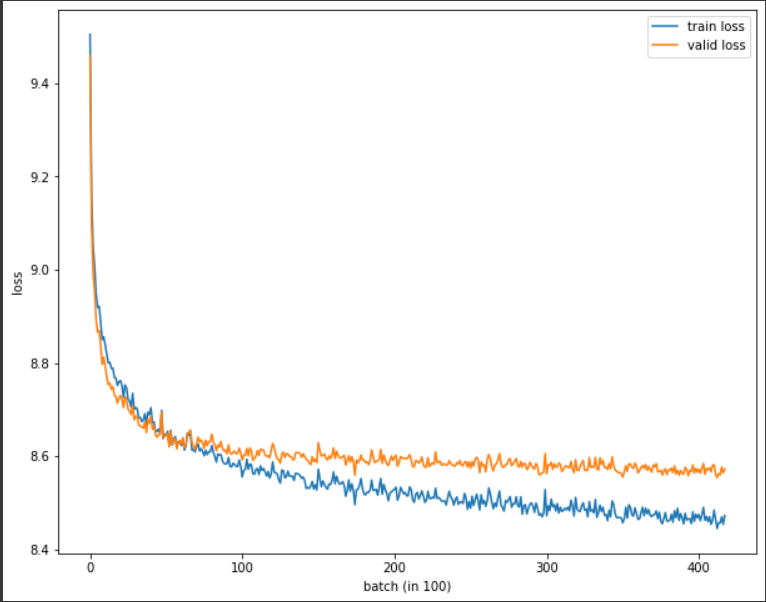

In [9]:
# display png image
from IPython.display import Image
Image(filename='q5_train_loss_chart.png')

從上圖同樣可看出，在訓練過程中，Training RMSE 與 Validation RMSE 在前幾千個 Batch 都在下降。  
而這邊相較於 Q2 的圖，Validation RMSE 似乎更小，且與 Training RMSE 的差距也比較小，代表模型可能有較好的 Generalization。

#### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

In [ ]:
q6_h_list = [20, 45, 180, 360]
test_rmse_list = []
for h in q6_h_list:
    print(f"Start training for h = {h}")
    mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=0,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5
    )
    mlp.fit(
        max_epoch=100,
        verbose=True,
        patience_batch_num=5000,
        model_path=f'q6_mlp_h_{h}.ckpt'
    )
    best_model = torch.load(f'q6_mlp_h_{h}.ckpt')
    test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
    test_rmse_list.append(test_rmse_loss)
    print(f"Test RMSE Loss for h = {h}: {test_rmse_loss}")

Start training for h = 20
Epoch: 0, Step: 100, Train Loss: 9.5200245485868, Valid Loss: 9.473878970533127
Epoch: 0, Step: 200, Train Loss: 9.155681479375327, Valid Loss: 9.103037489278522
Epoch: 0, Step: 300, Train Loss: 9.048587743011534, Valid Loss: 9.000576991066888
Epoch: 0, Step: 400, Train Loss: 8.981370225019269, Valid Loss: 8.933047292973816
Epoch: 1, Step: 500, Train Loss: 8.936449112436254, Valid Loss: 8.889940263354816
Epoch: 1, Step: 600, Train Loss: 8.91545739063537, Valid Loss: 8.86611002445239
Epoch: 1, Step: 700, Train Loss: 8.885559468197407, Valid Loss: 8.836600156222692
Epoch: 1, Step: 800, Train Loss: 8.8519678239549, Valid Loss: 8.809738843945533
Epoch: 2, Step: 900, Train Loss: 8.87204431715522, Valid Loss: 8.83389402192675
Epoch: 2, Step: 1000, Train Loss: 8.84360485930608, Valid Loss: 8.806929178630424
Epoch: 2, Step: 1100, Train Loss: 8.84601911392216, Valid Loss: 8.810785777265478
Epoch: 2, Step: 1200, Train Loss: 8.805173136088172, Valid Loss: 8.7651943307548

In [ ]:
# print rmse according to different h
for h, rmse in zip(q6_h_list, test_rmse_list):
    print(f"Test RMSE Loss for h = {h}: {rmse}")

Test RMSE Loss for h = 20: 8.779735188766702
Test RMSE Loss for h = 45: 8.761881446680928
Test RMSE Loss for h = 180: 8.769820182275133
Test RMSE Loss for h = 360: 8.763776141523703


從上面的結果並沒有看到在 H 不同的情況下，Test RMSE 有特別的走向，只能看出 45 個 Hidden Nodes 的 Test RMSE 最小，而 20 個 Hidden Nodes 的 Test RMSE 最大，但四個的差距都不大。  
而如果要預測的話，可能使用 45 個 Hidden Nodes 的模型比較好，因為其 Test RMSE 最小。


#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


In [ ]:
q7_mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=1,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=0.5
    )
train_loss_list, valid_loss_list = q7_mlp.fit(
    max_epoch=100,
    verbose=True,
    patience_batch_num=5000,
    model_path='q7_mlp.ckpt'
)

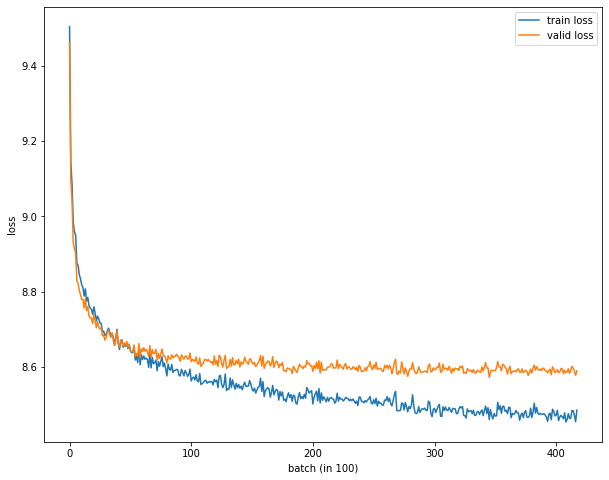

In [ ]:
# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
draw_loss(train_loss_list, valid_loss_list)

由上圖看出，使用 L2 + L1 Loss 的模型，其 Training RMSE 與 Validation RMSE 的走向與 Q2 的模型非常類似，  
都是在 20000 個 batches 後趨於平坦，不再往下掉。但 training RMSE 還在持續變小，代表可能開始產生 overfitting。

In [11]:
best_q7_mlp = torch.load('q7_mlp.ckpt', map_location=torch.device('cpu'))
test_rmse_loss = calculate_test_rmse(best_q7_mlp, X_test, Y_test)
print(f"Test RMSE Loss: {test_rmse_loss}")

Test RMSE Loss: 8.765939005064949


In [ ]:
q7_z_list = [0.0, 0.1, 0.9, 1.0]
test_rmse_list = []
for z in q7_z_list:
    print(f"Start training for z = {z}")
    mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=1,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=z
    )
    mlp.fit(
        max_epoch=100,
        verbose=True,
        patience_batch_num=5000,
        model_path=f'q7_mlp_z_{z}.ckpt'
    )
    best_model = torch.load(f'q7_mlp_z_{z}.ckpt')
    test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
    test_rmse_list.append(test_rmse_loss)
    print(f"Test RMSE Loss for z = {z}: {test_rmse_loss}")

Start training for z = 0.0
Epoch: 0, Step: 100, Train Loss: 10.568008681423535, Valid Loss: 10.545305744468624
Epoch: 0, Step: 200, Train Loss: 10.244463937791938, Valid Loss: 10.213576781455055
Epoch: 0, Step: 300, Train Loss: 9.458251384860587, Valid Loss: 9.41430764362261
Epoch: 0, Step: 400, Train Loss: 9.41171436190192, Valid Loss: 9.3738754802239
Epoch: 1, Step: 500, Train Loss: 9.324685968835528, Valid Loss: 9.279818341572689
Epoch: 1, Step: 600, Train Loss: 9.257497427823829, Valid Loss: 9.21137516502447
Epoch: 1, Step: 700, Train Loss: 9.187845242226022, Valid Loss: 9.137731225882197
Epoch: 1, Step: 800, Train Loss: 9.207033785250431, Valid Loss: 9.162330928393407
Epoch: 2, Step: 900, Train Loss: 9.12120883401235, Valid Loss: 9.073539669715084
Epoch: 2, Step: 1000, Train Loss: 9.125982152440171, Valid Loss: 9.08499711129202
Epoch: 2, Step: 1100, Train Loss: 9.103000430873472, Valid Loss: 9.059953323932415
Epoch: 2, Step: 1200, Train Loss: 9.051066813343297, Valid Loss: 9.00396

In [ ]:
# print rmse according to different z
for z, rmse in zip(q7_z_list, test_rmse_list):
    print(f"Test RMSE Loss for z = {z}: {rmse}")

Test RMSE Loss for z = 0.0: 8.994984392072922
Test RMSE Loss for z = 0.1: 8.773821661899284
Test RMSE Loss for z = 0.9: 8.771708431376377
Test RMSE Loss for z = 1.0: 8.756946007933966


這邊可以看出隨著 z 的增加，Test RMSE 也隨之減少，在 z = 1.0 時達到最小值，且與前面使用 SSE 的模型相比，Test RMSE 也有所下降，代表 L2 + L1 Loss 的模型或許有更好的效果。


#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


Epoch: 0, Step: 100, Train Loss: 10.578546137578007, Valid Loss: 10.553734897612387
Epoch: 0, Step: 200, Train Loss: 10.220429130390361, Valid Loss: 10.190562216087955
Epoch: 0, Step: 300, Train Loss: 9.489304815806562, Valid Loss: 9.444216188322997
Epoch: 0, Step: 400, Train Loss: 9.402771643210336, Valid Loss: 9.359018009944043
Epoch: 1, Step: 500, Train Loss: 9.292622011718226, Valid Loss: 9.241579265413444
Epoch: 1, Step: 600, Train Loss: 9.250229869662338, Valid Loss: 9.197656121735225
Epoch: 1, Step: 700, Train Loss: 9.273896017248422, Valid Loss: 9.231596072532504
Epoch: 1, Step: 800, Train Loss: 9.16856741989957, Valid Loss: 9.123681948756127
Epoch: 2, Step: 900, Train Loss: 9.20184042981072, Valid Loss: 9.159848907032274
Epoch: 2, Step: 1000, Train Loss: 9.12078132117568, Valid Loss: 9.077893984527691
Epoch: 2, Step: 1100, Train Loss: 9.142978716929974, Valid Loss: 9.09921184196025
Epoch: 2, Step: 1200, Train Loss: 9.142153313496227, Valid Loss: 9.097422560163482
Epoch: 3, Ste

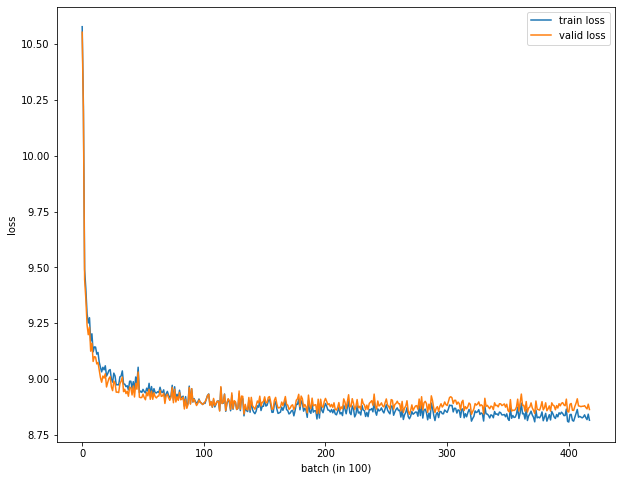

In [ ]:
q8_mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=2,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=0
    )
train_loss_list, valid_loss_list = q8_mlp.fit(
    max_epoch=100,
    verbose=True,
    patience_batch_num=5000,
    model_path='q8_mlp.ckpt'
)

# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
draw_loss(train_loss_list, valid_loss_list)

從上圖看出，使用了 $qloss$ 的模型，其 validation 與 training RMSE 幾乎重疊在一起，而且都在持續下降，可以知道這個模型並沒有 overfitting 的問題，並在 validation set 上的表現相當成功。  
而模型看起來非常穩定，如果繼續訓練下去，可能會有更好的效果。

In [ ]:
q8_z_list = [0.1, 0.5, 0.9, 1.0]
test_rmse_list = []
for z in q8_z_list:
    print(f"Start training for z = {z}")
    mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=2,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=z
    )
    mlp.fit(
        max_epoch=100,
        verbose=True,
        patience_batch_num=5000,
        model_path=f'q8_mlp_z_{z}.ckpt'
    )
    best_model = torch.load(f'q8_mlp_z_{z}.ckpt')
    test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
    test_rmse_list.append(test_rmse_loss)
    print(f"Test RMSE Loss for z = {z}: {test_rmse_loss}")

Start training for z = 0.1
Epoch: 0, Step: 100, Train Loss: 9.59568658071178, Valid Loss: 9.556662448029432
Epoch: 0, Step: 200, Train Loss: 9.186549833133588, Valid Loss: 9.129590306425355
Epoch: 0, Step: 300, Train Loss: 9.062005197028787, Valid Loss: 9.009085273488285
Epoch: 0, Step: 400, Train Loss: 8.986552887575602, Valid Loss: 8.923914393712305
Epoch: 1, Step: 500, Train Loss: 8.950722429326845, Valid Loss: 8.892893561319685
Epoch: 1, Step: 600, Train Loss: 8.918929618030305, Valid Loss: 8.866361499803723
Epoch: 1, Step: 700, Train Loss: 8.897622664489214, Valid Loss: 8.841943676250697
Epoch: 1, Step: 800, Train Loss: 8.87349802768574, Valid Loss: 8.824858528580183
Epoch: 2, Step: 900, Train Loss: 8.849314026710028, Valid Loss: 8.801689635569245
Epoch: 2, Step: 1000, Train Loss: 8.842636055929189, Valid Loss: 8.798826581868157
Epoch: 2, Step: 1100, Train Loss: 8.827808162983768, Valid Loss: 8.782592238933013
Epoch: 2, Step: 1200, Train Loss: 8.840197516082108, Valid Loss: 8.8019

In [ ]:
# print rmse according to different z
for z, rmse in zip(q8_z_list, test_rmse_list):
    print(f"Test RMSE Loss for z = {z}: {rmse}")

Test RMSE Loss for z = 0.1: 8.750706457881472
Test RMSE Loss for z = 0.5: 8.779484543662651
Test RMSE Loss for z = 0.9: 8.768688801255555
Test RMSE Loss for z = 1.0: 8.776299084557824


這裡不同的 z 值所產生的 Test RMSE 就沒有像前一題一樣有明顯的走向，有趣的是前一題 z 是最大值時，Test RMSE 最小，但這裡卻是 z = 0.1 時 Test RMSE 最小。  
而且與前面使用 SSE 的模型相比，$8.75$ 的 Test RMSE 是最低的，代表 $qloss$ 的模型在這個資料集的下有最好的表現。